# Motor activity and phase dynamics

How does the phase evolve over time? What happens to it when the fish is moving? This is what  we will investigate in this notebook.

In [84]:
%matplotlib widget
import lotr.plotting as pltltr
import numpy as np
import pandas as pd
from lotr import A_FISH, FIGURES_LOCATION, LotrExperiment, dataset_folders
from lotr.behavior import get_fictive_heading
from matplotlib import pyplot as plt
from tqdm import tqdm

COLS = pltltr.COLS

fig_location = FIGURES_LOCATION / "4_phase_dynamics"
fig_location.mkdir(exist_ok=True)

## Stability of the network over time

First of all, we want to check whether the network crosses all phases with similar probability. We will use the function for calculating network phase defined in notebook 2.

First of all, let's look at the histogram over the full experiment for all fish:

In [85]:
# Load phases from all fish:
phases = [LotrExperiment(path).network_phase for path in tqdm(dataset_folders)]

100%|███████████████████████████████████████████| 31/31 [00:45<00:00,  1.48s/it]


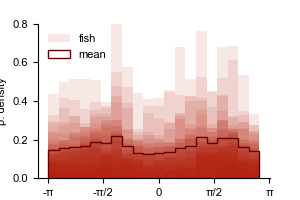

In [86]:
f, ax = plt.subplots(figsize=(3, 2))
hist_base = np.arange(-np.pi, np.pi, 0.3)
for i, ph in enumerate(phases):
    plt.hist(
        ph,
        hist_base,
        fc=COLS["ph_plot"],
        lw=0,
        density=True,
        alpha=0.1,
        label="fish" if i == 0 else "_nolegend_",
    )

plt.hist(
    np.concatenate(phases),
    hist_base,
    density=True,
    histtype="step",
    lw=1,
    label="mean",
    ec=pltltr.dark_col(COLS["ph_plot"], 0.3),
)
ax.set(xlabel="phase", ylabel="p. density", ylim=(0, 0.8), **pltltr.get_pi_labels(0.5))
pltltr.despine(ax)
ax.legend()
plt.show()
plt.tight_layout()

pltltr.savefig(fig_location / "all_network_phase_hist.pdf")

This looks quite flat! We'll come back later to this result. But for now, it is interesting to see that there is no location of consistent preferential activation across fish.

## Dynamics of the network and behavior

Let's now get to the main point: what happens to the phase when the fish is performing directional motion?

We will start with a very naive approach, simply cropping phase after every single directional bout to see how it changes. From now on, we will work with the [np.unwrap](https://numpy.org/doc/stable/reference/generated/numpy.unwrap.html)ed version of the phase, to avoid jumps from `-pi` to `pi`

In [87]:
from lotr.utils import crop, resample_matrix

In [88]:
exp = LotrExperiment(A_FISH)
unwrapped_ph = np.unwrap(exp.network_phase)
directions = ["rt", "lf", "fw"]

pre_wnd_s, post_wnd_s = 10, 25

In [89]:
cropped_dict = dict()
for d in directions:
    idxs = exp.bouts_df.loc[exp.bouts_df["direction"] == d, "idx_imaging"]
    cropped = crop(
        unwrapped_ph, idxs, pre_int=pre_wnd_s * exp.fn, post_int=post_wnd_s * exp.fn,
    )
    cropped_dict[d] = cropped - np.mean(cropped[: pre_wnd_s * exp.fn, :], 0)

time_arr = np.arange(cropped.shape[0]) / exp.fn - pre_wnd_s

In [90]:
def dark_col(col, val=0.2):
    if type(col) == str:
        col = [float(col) for _ in range(3)]
    return [max(0, c - val) for c in col]

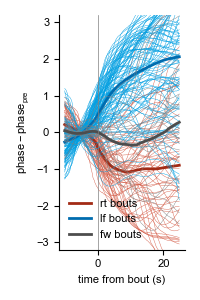

In [91]:
f, ax = plt.subplots(figsize=(2, 3))
for d in directions:
    plt.plot(time_arr, cropped_dict[d], lw=0.3, c=COLS["sides"][d], label="_nolabel_")
    plt.plot(
        time_arr,
        cropped_dict[d].mean(1),
        lw=2,
        c=pltltr.dark_col(COLS["sides"][d]),
        label=f"{d} bouts",
    )


pltltr.despine(ax)
ax.set(xlabel="time from bout (s)", ylabel="$phase-phase_{pre}$", ylim=(-3.2, 3.2))
ax.legend()
plt.axvline(0, lw=0.5, c=".5")
plt.tight_layout()

pltltr.savefig(fig_location / "bout_trig_phase_change_onefish.pdf")

## Crop phase changes across all fish

We can crop in a similar way events from all fish in the dataset.

In [92]:
FN = 5  # we impose a sampling frequency, this will exclude 1/31 fish

directions = ["rt", "lf", "fw"]
pre_wnd_s, post_wnd_s = 10, 25

all_phase_cropped = []
all_head_cropped = []

# We will create a dataframe to keep track of events from all fish.
# Mostly a way of keeping together the crop and the bouts:
events_df = []

time_arr = np.arange(1, ((pre_wnd_s + post_wnd_s) * FN) + 1) / exp.fn - pre_wnd_s
for path in tqdm(dataset_folders):
    exp = LotrExperiment(path)

    unwrapped_ph = np.unwrap(exp.network_phase)
    fictive_head = get_fictive_heading(exp.n_pts, exp.bouts_df)

    for d in directions:
        sel_bouts = exp.bouts_df.loc[exp.bouts_df["direction"] == d, :]

        events_df.append(sel_bouts.reindex())

        for dest_list, to_crop in zip(
            [all_phase_cropped, all_head_cropped], [unwrapped_ph, fictive_head]
        ):

            cropped = crop(
                to_crop,
                sel_bouts["idx_imaging"],
                pre_int=pre_wnd_s * exp.fn,
                post_int=post_wnd_s * exp.fn,
            )

            # Subtract baseline:
            cropped = cropped - np.mean(cropped[: pre_wnd_s * exp.fn, :], 0)

            # Interpolate if necessary:
            if exp.fn != FN:
                fish_time_arr = np.arange(1, cropped.shape[0] + 1) / exp.fn - pre_wnd_s
                cropped = resample_matrix(time_arr, fish_time_arr, cropped)

            dest_list.append(cropped)

all_phase_cropped = np.concatenate(all_phase_cropped, axis=1)
all_head_cropped = np.concatenate(all_head_cropped, axis=1)
events_df = pd.concat(events_df, ignore_index=True)

100%|███████████████████████████████████████████| 31/31 [00:46<00:00,  1.50s/it]


In [95]:
all_phase_cropped.shape

(175, 9975)

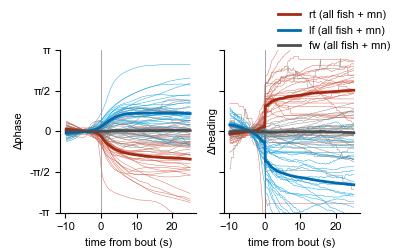

In [93]:
f, axs = plt.subplots(
    1,
    2,
    figsize=(4, 2.5),
    gridspec_kw=dict(left=0.15, bottom=0.15, top=0.8),
    sharey=True,
)

for ax, lab, all_cropped in zip(
    axs, ["Δphase", "Δheading"], [all_phase_cropped, all_head_cropped]
):
    for d in directions:
        fish_means = []
        for fid in events_df.fid.unique():
            sel = (events_df["direction"] == d) & (events_df["fid"] == fid)
            if sum(sel) > 0:
                fish_means.append(all_cropped[:, sel].mean(1))
        fish_means = np.array(fish_means)

        ax.plot(
            time_arr, fish_means.T, lw=0.3, c=COLS["sides"][d], label="_nolabel_",
        )
        ax.plot(
            time_arr,
            np.mean(fish_means, 0),
            lw=2,
            c=pltltr.dark_col(COLS["sides"][d]),
            label=f"{d} (all fish + mn)",
            zorder=30,
        )

    pltltr.despine(ax)
    ax.set(
        xlabel="time from bout (s)",
        ylim=(-2.5, 2.5),
        ylabel=lab,
        **pltltr.get_pi_labels(0.5, ax="y"),
    )
    ax.axvline(0, lw=0.5, c=".5")
axs[0].legend(bbox_to_anchor=(1, 1), bbox_transform=plt.gcf().transFigure)
# plt.tight_layout()

pltltr.savefig(fig_location / "bout_trig_phase_head_change_onefish.pdf")

Note that we have not introduced any arbitrary sign flip to get to this plot, we just imposed a registration with the anatomy, and for free we get such an agreement of phase changes across fish! 
If we consider the convention for phase definition:
 - **left bouts induce cw rotations**
 - **right bouts induce ccw rotations**
 
In finalizing those statements we should make sure we cross check everything 10 times, but I looked again at the following:
 - definition of left and right bouts can be cross-checked using localization of motor selective ROIs as the reference. With our definition of left and right bouts, we get left bouts activating left side of aHB, and right bouts activating right side of aHB (consistent with e.g. Chen et al 2018)
 - our definition of phase rotation is consistent with visual inspection of data for A_FISH dataset